<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/main/C4/W4/ungraded_labs/C4_W4_Lab_3_Sunspots_CNN_RNN_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Sunspots with more Neural Network configuration

Use combined configuration of networks: the data windows will pass through a convolution, followed by stacked LSTMs, followed by stacked dense layers. The object is to See if this improves results than the results predicted by simpler models.

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

/Users/jingyiliu/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Visualization for plotting.

In [6]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 4))

    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

In [4]:
# Download the Dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv

--2024-07-28 17:31:40--  https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.68.59, 142.250.72.155, 142.251.40.59, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.68.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [text/csv]
Saving to: ‘Sunspots.csv.1’

Sunspots.csv.1      100%[===================>]  69.17K  --.-KB/s    in 0.01s   

2024-07-28 17:31:40 (6.55 MB/s) - ‘Sunspots.csv.1’ saved [70827/70827]



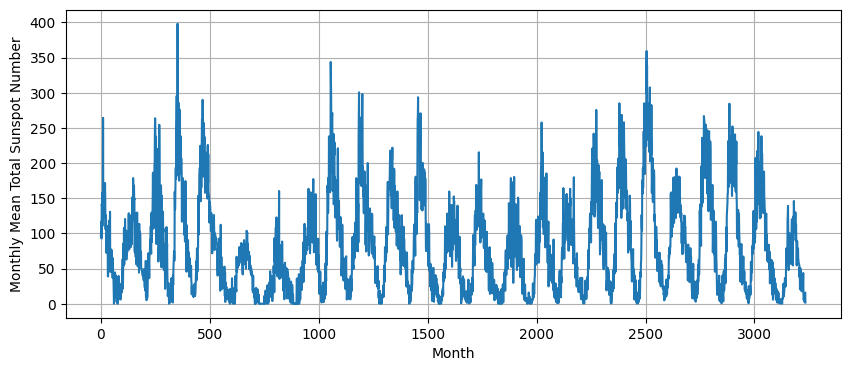

In [7]:
# Initialize lists
time_step = []
sunspots = []

# Open CSV file
with open('./Sunspots.csv') as csvfile:

  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')

  # Skip the first line
  next(reader)

  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    sunspots.append(float(row[2]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(sunspots)

# Preview the data
plot_series(time, series, xlabel='Month', ylabel='Monthly Mean Total Sunspot Number')

# Split the Dataset

In [8]:
# Define the split time
split_time = 3000

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

# Prepare Features and Labels

In [10]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [11]:
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# Build the Model

In [12]:
# Build the Model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

 # Print the model summary
model.summary()

/Users/jingyiliu/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 30, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 30, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │         1,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,575 (267.87 KB)

 Trainable params: 68,575 (267.87 KB)

 Non-trainable params: 0 (0.00 B)

# Tune the Learning Rate
Pick an optimal learning rate.

In [13]:
# Get initial weights
init_weights = model.get_weights()

In [14]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 101.9854 - learning_rate: 1.0000e-08
Epoch 2/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 92.6510

2024-07-28 17:33:26.525037: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/contextlib.py:135: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(type, value, traceback)


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 88.4806 - learning_rate: 1.1220e-08
Epoch 3/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 50.5168

2024-07-28 17:33:27.707825: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 47.7750 - learning_rate: 1.2589e-08
Epoch 4/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 45.4632

2024-07-28 17:33:28.885069: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 41.7489 - learning_rate: 1.4125e-08
Epoch 5/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 38.5293

2024-07-28 17:33:30.110619: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 38.9982 - learning_rate: 1.5849e-08
Epoch 6/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 37.3965

2024-07-28 17:33:31.289869: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 37.5238 - learning_rate: 1.7783e-08
Epoch 7/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 34.2825

2024-07-28 17:33:32.464873: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 35.9763 - learning_rate: 1.9953e-08
Epoch 8/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 30.1871

2024-07-28 17:33:33.644472: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 34.0137 - learning_rate: 2.2387e-08
Epoch 9/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 32.4652

2024-07-28 17:33:34.825406: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 33.3399 - learning_rate: 2.5119e-08
Epoch 10/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 32.2579

2024-07-28 17:33:36.002223: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 33.7617 - learning_rate: 2.8184e-08
Epoch 11/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 32.3202

2024-07-28 17:33:37.183108: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 32.2090 - learning_rate: 3.1623e-08
Epoch 12/100
 6/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 32.1544

2024-07-28 17:33:38.351438: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 32.2645 - learning_rate: 3.5481e-08
Epoch 13/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 31.5185

2024-07-28 17:33:39.540160: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 30.6452 - learning_rate: 3.9811e-08
Epoch 14/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 31.7597

2024-07-28 17:33:40.737886: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 30.8206 - learning_rate: 4.4668e-08
Epoch 15/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 32.0887

2024-07-28 17:33:41.940070: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 29.1099 - learning_rate: 5.0119e-08
Epoch 16/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 29.3757

2024-07-28 17:33:43.128629: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 28.9802 - learning_rate: 5.6234e-08
Epoch 17/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 28.9127

2024-07-28 17:33:44.286639: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 28.3042 - learning_rate: 6.3096e-08
Epoch 18/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 22.7517

2024-07-28 17:33:45.464038: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 26.1950 - learning_rate: 7.0795e-08
Epoch 19/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 26.5397

2024-07-28 17:33:46.638381: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 26.5539 - learning_rate: 7.9433e-08
Epoch 20/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 27.2335

2024-07-28 17:33:47.811888: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 26.5778 - learning_rate: 8.9125e-08
Epoch 21/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 24.8354

2024-07-28 17:33:48.984672: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 25.0703 - learning_rate: 1.0000e-07
Epoch 22/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 24.7278

2024-07-28 17:33:50.172289: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 25.0174 - learning_rate: 1.1220e-07
Epoch 23/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 24.6484

2024-07-28 17:33:51.425853: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 24.4212 - learning_rate: 1.2589e-07
Epoch 24/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 21.9883

2024-07-28 17:33:52.596014: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 23.3569 - learning_rate: 1.4125e-07
Epoch 25/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 23.0826

2024-07-28 17:33:53.807471: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 23.4382 - learning_rate: 1.5849e-07
Epoch 26/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 21.7896

2024-07-28 17:33:55.016489: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 23.1184 - learning_rate: 1.7783e-07
Epoch 27/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 23.9528

2024-07-28 17:33:56.236309: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 23.2305 - learning_rate: 1.9953e-07
Epoch 28/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 21.1928

2024-07-28 17:33:57.430483: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 22.1556 - learning_rate: 2.2387e-07
Epoch 29/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 19.8497

2024-07-28 17:33:58.617098: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 21.7226 - learning_rate: 2.5119e-07
Epoch 30/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 20.1366

2024-07-28 17:33:59.780398: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 21.2164 - learning_rate: 2.8184e-07
Epoch 31/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 20.8825

2024-07-28 17:34:00.948802: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 21.4641 - learning_rate: 3.1623e-07
Epoch 32/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 22.1743

2024-07-28 17:34:02.157089: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 21.3478 - learning_rate: 3.5481e-07
Epoch 33/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 20.3502

2024-07-28 17:34:03.338470: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 20.7843 - learning_rate: 3.9811e-07
Epoch 34/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 24.2129

2024-07-28 17:34:04.517702: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 21.7449 - learning_rate: 4.4668e-07
Epoch 35/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 20.6595

2024-07-28 17:34:05.752219: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 20.5528 - learning_rate: 5.0119e-07
Epoch 36/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 18.9014

2024-07-28 17:34:06.923925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 20.3741 - learning_rate: 5.6234e-07
Epoch 37/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.5730

2024-07-28 17:34:08.094266: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 19.6647 - learning_rate: 6.3096e-07
Epoch 38/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 21.1169

2024-07-28 17:34:09.264155: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 20.7554 - learning_rate: 7.0795e-07
Epoch 39/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 20.6132

2024-07-28 17:34:10.454446: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 20.2646 - learning_rate: 7.9433e-07
Epoch 40/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 19.6147

2024-07-28 17:34:11.620002: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 20.3935 - learning_rate: 8.9125e-07
Epoch 41/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 19.1292

2024-07-28 17:34:12.786419: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 21.2306 - learning_rate: 1.0000e-06
Epoch 42/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 19.4163

2024-07-28 17:34:13.958969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 20.1267 - learning_rate: 1.1220e-06
Epoch 43/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 18.7182

2024-07-28 17:34:15.135411: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 19.5337 - learning_rate: 1.2589e-06
Epoch 44/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 21.1472

2024-07-28 17:34:16.317035: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 20.7667 - learning_rate: 1.4125e-06
Epoch 45/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 19.5361

2024-07-28 17:34:17.482794: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 21.3498 - learning_rate: 1.5849e-06
Epoch 46/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 18.1215

2024-07-28 17:34:18.650127: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 19.8698 - learning_rate: 1.7783e-06
Epoch 47/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 20.0475

2024-07-28 17:34:19.913321: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 20.3035 - learning_rate: 1.9953e-06
Epoch 48/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 18.4107

2024-07-28 17:34:21.064525: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 19.5522 - learning_rate: 2.2387e-06
Epoch 49/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 18.8902

2024-07-28 17:34:22.218433: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 20.3477 - learning_rate: 2.5119e-06
Epoch 50/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 18.2294

2024-07-28 17:34:23.373072: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 18.4577 - learning_rate: 2.8184e-06
Epoch 51/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 19.7087

2024-07-28 17:34:24.523362: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 19.6587 - learning_rate: 3.1623e-06
Epoch 52/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 20.9071

2024-07-28 17:34:25.690064: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 20.0225 - learning_rate: 3.5481e-06
Epoch 53/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 21.9299

2024-07-28 17:34:26.841875: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 19.7428 - learning_rate: 3.9811e-06
Epoch 54/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 18.2333

2024-07-28 17:34:27.988596: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 19.3356 - learning_rate: 4.4668e-06
Epoch 55/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 23.1755

2024-07-28 17:34:29.159703: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 21.6017 - learning_rate: 5.0119e-06
Epoch 56/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 28.4572

2024-07-28 17:34:30.305734: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 22.9726 - learning_rate: 5.6234e-06
Epoch 57/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 21.5562

2024-07-28 17:34:31.452436: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 20.1909 - learning_rate: 6.3096e-06
Epoch 58/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 20.9645

2024-07-28 17:34:32.595150: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 20.5176 - learning_rate: 7.0795e-06
Epoch 59/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 19.7689

2024-07-28 17:34:33.750976: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 20.0471 - learning_rate: 7.9433e-06
Epoch 60/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 19.3886

2024-07-28 17:34:34.899201: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 19.8371 - learning_rate: 8.9125e-06
Epoch 61/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 21.7192

2024-07-28 17:34:36.082978: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 20.1121 - learning_rate: 1.0000e-05
Epoch 62/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 17.8908

2024-07-28 17:34:37.248876: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 19.0441 - learning_rate: 1.1220e-05
Epoch 63/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 18.5845

2024-07-28 17:34:38.430550: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 19.8070 - learning_rate: 1.2589e-05
Epoch 64/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 21.5998

2024-07-28 17:34:39.624605: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 20.7452 - learning_rate: 1.4125e-05
Epoch 65/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 20.5563

2024-07-28 17:34:40.893291: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 21.2857 - learning_rate: 1.5849e-05
Epoch 66/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 23.4637

2024-07-28 17:34:42.072709: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 21.6387 - learning_rate: 1.7783e-05
Epoch 67/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 17.4086

2024-07-28 17:34:43.241356: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 20.1026 - learning_rate: 1.9953e-05
Epoch 68/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 21.8905

2024-07-28 17:34:44.410207: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 21.7746 - learning_rate: 2.2387e-05
Epoch 69/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 21.3683

2024-07-28 17:34:45.596409: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 22.4917 - learning_rate: 2.5119e-05
Epoch 70/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 28.0814

2024-07-28 17:34:46.763749: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 24.4972 - learning_rate: 2.8184e-05
Epoch 71/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 22.4188

2024-07-28 17:34:47.931761: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 19.8243 - learning_rate: 3.1623e-05
Epoch 72/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 18.1564

2024-07-28 17:34:49.101749: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 20.4698 - learning_rate: 3.5481e-05
Epoch 73/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 20.1037

2024-07-28 17:34:50.307125: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 20.7327 - learning_rate: 3.9811e-05
Epoch 74/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 20.5647

2024-07-28 17:34:51.486583: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 22.7542 - learning_rate: 4.4668e-05
Epoch 75/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 27.6947

2024-07-28 17:34:52.664223: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 25.2192 - learning_rate: 5.0119e-05
Epoch 76/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 30.7396

2024-07-28 17:34:53.848644: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 27.1834 - learning_rate: 5.6234e-05
Epoch 77/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 25.3809

2024-07-28 17:34:55.010076: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 23.2734 - learning_rate: 6.3096e-05
Epoch 78/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 18.8382

2024-07-28 17:34:56.177071: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 21.1851 - learning_rate: 7.0795e-05
Epoch 79/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 21.9712

2024-07-28 17:34:57.369556: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 22.2285 - learning_rate: 7.9433e-05
Epoch 80/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 30.6342

2024-07-28 17:34:58.554909: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 29.0013 - learning_rate: 8.9125e-05
Epoch 81/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 22.0763

2024-07-28 17:34:59.737308: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 23.5605 - learning_rate: 1.0000e-04
Epoch 82/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 30.4411

2024-07-28 17:35:00.910115: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 26.8506 - learning_rate: 1.1220e-04
Epoch 83/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 22.6542

2024-07-28 17:35:02.086345: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 22.5473 - learning_rate: 1.2589e-04
Epoch 84/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 21.6383

2024-07-28 17:35:03.253140: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 25.4621 - learning_rate: 1.4125e-04
Epoch 85/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 33.1468

2024-07-28 17:35:04.465110: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 29.3678 - learning_rate: 1.5849e-04
Epoch 86/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 37.1265

2024-07-28 17:35:05.636412: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 32.1317 - learning_rate: 1.7783e-04
Epoch 87/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 26.3818

2024-07-28 17:35:06.805602: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 29.9876 - learning_rate: 1.9953e-04
Epoch 88/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 40.6997

2024-07-28 17:35:07.986220: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 36.4003 - learning_rate: 2.2387e-04
Epoch 89/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 47.3679

2024-07-28 17:35:09.194091: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 37.2275 - learning_rate: 2.5119e-04
Epoch 90/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 38.2816

2024-07-28 17:35:10.434258: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 36.3242 - learning_rate: 2.8184e-04
Epoch 91/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 47.1994

2024-07-28 17:35:11.647365: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 42.4447 - learning_rate: 3.1623e-04
Epoch 92/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 49.4884

2024-07-28 17:35:12.822573: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 54.6218 - learning_rate: 3.5481e-04
Epoch 93/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 47.7409

2024-07-28 17:35:14.003232: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 55.7902 - learning_rate: 3.9811e-04
Epoch 94/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 54.0639

2024-07-28 17:35:15.186459: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 54.3490 - learning_rate: 4.4668e-04
Epoch 95/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 61.3860

2024-07-28 17:35:16.366238: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 64.9921 - learning_rate: 5.0119e-04
Epoch 96/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 61.5919

2024-07-28 17:35:17.535475: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 64.5169 - learning_rate: 5.6234e-04
Epoch 97/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 58.8377

2024-07-28 17:35:18.719416: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 57.5790 - learning_rate: 6.3096e-04
Epoch 98/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 57.2682

2024-07-28 17:35:19.935939: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 60.9580 - learning_rate: 7.0795e-04
Epoch 99/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 61.5269

2024-07-28 17:35:21.113329: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 64.7145 - learning_rate: 7.9433e-04
Epoch 100/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 94.6415 

2024-07-28 17:35:22.285506: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 82.9441 - learning_rate: 8.9125e-04


2024-07-28 17:35:23.463301: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


(1e-08, 0.001, 0.0, 100.0)

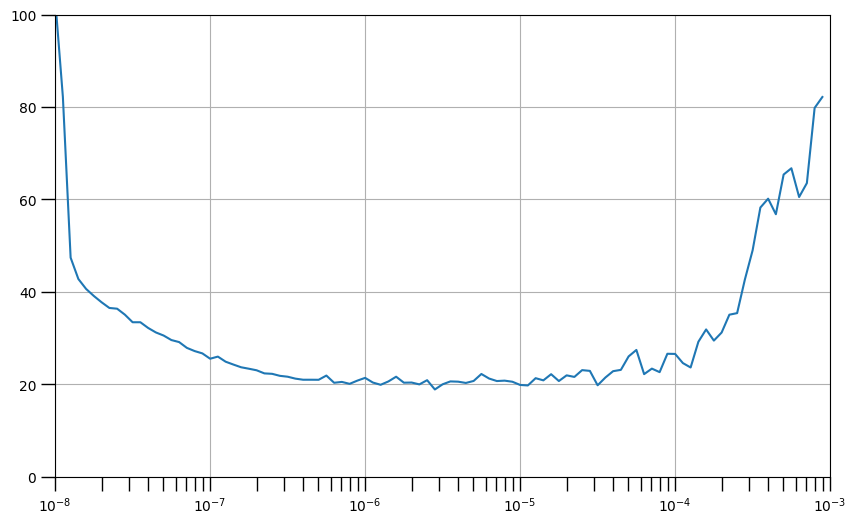

In [15]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

# Train the Model

In [16]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [17]:
# Set the learning rate
learning_rate = 4e-6

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [18]:
# Train the model
history = model.fit(train_set,epochs=100)

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 43.1165 - mae: 43.6127
Epoch 2/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 28.3638 - mae: 28.8627

2024-07-28 17:36:29.045589: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/contextlib.py:135: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(type, value, traceback)


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 25.0455 - mae: 25.5412
Epoch 3/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 20.9103 - mae: 21.4027

2024-07-28 17:36:30.236237: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 22.2289 - mae: 22.7226
Epoch 4/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 20.9214 - mae: 21.4146

2024-07-28 17:36:31.450377: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 21.6927 - mae: 22.1870
Epoch 5/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 19.0848 - mae: 19.5810

2024-07-28 17:36:32.668946: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 19.2462 - mae: 19.7392
Epoch 6/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 19.4249 - mae: 19.9202

2024-07-28 17:36:33.851014: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 19.4770 - mae: 19.9711
Epoch 7/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 17.7515 - mae: 18.2466

2024-07-28 17:36:35.039448: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 18.6424 - mae: 19.1359
Epoch 8/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 20.4305 - mae: 20.9239

2024-07-28 17:36:36.276450: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 19.7430 - mae: 20.2369
Epoch 9/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 17.6429 - mae: 18.1263

2024-07-28 17:36:37.449778: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 19.0600 - mae: 19.5519
Epoch 10/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 15.9837 - mae: 16.4758

2024-07-28 17:36:38.647499: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.9974 - mae: 18.4895
Epoch 11/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 18.2528 - mae: 18.7422

2024-07-28 17:36:39.821787: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 18.6764 - mae: 19.1668
Epoch 12/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 19.9504 - mae: 20.4448

2024-07-28 17:36:40.995778: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 18.8637 - mae: 19.3579
Epoch 13/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 18.6559 - mae: 19.1518

2024-07-28 17:36:42.169314: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 18.0893 - mae: 18.5824
Epoch 14/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 18.8990 - mae: 19.3938

2024-07-28 17:36:43.342117: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 19.2564 - mae: 19.7476
Epoch 15/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 18.8472 - mae: 19.3378

2024-07-28 17:36:44.520916: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 19.0058 - mae: 19.4973
Epoch 16/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 20.9307 - mae: 21.4196

2024-07-28 17:36:45.696146: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 19.6393 - mae: 20.1309
Epoch 17/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 17.9983 - mae: 18.4927

2024-07-28 17:36:46.862729: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 18.2752 - mae: 18.7682
Epoch 18/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 16.4584 - mae: 16.9510

2024-07-28 17:36:48.043251: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 18.1952 - mae: 18.6871
Epoch 19/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 21.6473 - mae: 22.1448

2024-07-28 17:36:49.208726: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 18.9534 - mae: 19.4484
Epoch 20/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 16.3722 - mae: 16.8618

2024-07-28 17:36:50.388300: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.7842 - mae: 18.2767
Epoch 21/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.6625 - mae: 18.1537

2024-07-28 17:36:51.590990: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 19.2653 - mae: 19.7580
Epoch 22/100
 3/93 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 19.1753 - mae: 19.6642

2024-07-28 17:36:52.763960: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 18.1752 - mae: 18.6655
Epoch 23/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 18.0660 - mae: 18.5615

2024-07-28 17:36:53.999360: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 18.5488 - mae: 19.0428
Epoch 24/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 17.3985 - mae: 17.8823

2024-07-28 17:36:55.197056: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 17.6273 - mae: 18.1172
Epoch 25/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 18.2841 - mae: 18.7772

2024-07-28 17:36:56.439162: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 18.7807 - mae: 19.2704
Epoch 26/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 18.8878 - mae: 19.3843

2024-07-28 17:36:57.621304: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.9902 - mae: 18.4831
Epoch 27/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 17.5164 - mae: 18.0086

2024-07-28 17:36:58.794768: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 18.2847 - mae: 18.7758
Epoch 28/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 18.3348 - mae: 18.8259

2024-07-28 17:36:59.971021: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 18.0724 - mae: 18.5650
Epoch 29/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 15.1583 - mae: 15.6544

2024-07-28 17:37:01.205636: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.4809 - mae: 17.9736
Epoch 30/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 16.4551 - mae: 16.9493

2024-07-28 17:37:02.396093: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.6296 - mae: 18.1230
Epoch 31/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 15.6104 - mae: 16.1021

2024-07-28 17:37:03.569866: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.3973 - mae: 17.8889
Epoch 32/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.2711 - mae: 17.7646

2024-07-28 17:37:04.752137: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 17.2901 - mae: 17.7818
Epoch 33/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 18.5825 - mae: 19.0770

2024-07-28 17:37:06.018292: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 18.3074 - mae: 18.8011
Epoch 34/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 16.8722 - mae: 17.3649

2024-07-28 17:37:07.347187: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 18.2941 - mae: 18.7863
Epoch 35/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 15.9638 - mae: 16.4541

2024-07-28 17:37:08.526915: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.4617 - mae: 17.9533
Epoch 36/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.1187 - mae: 17.6076

2024-07-28 17:37:09.698862: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 18.6562 - mae: 19.1467
Epoch 37/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 16.1978 - mae: 16.6812

2024-07-28 17:37:10.869658: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 17.7617 - mae: 18.2537
Epoch 38/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.7919 - mae: 18.2859

2024-07-28 17:37:12.094849: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.8693 - mae: 18.3619
Epoch 39/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 16.6489 - mae: 17.1378

2024-07-28 17:37:13.264608: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.3991 - mae: 17.8901
Epoch 40/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 15.2453 - mae: 15.7374

2024-07-28 17:37:14.428312: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.3228 - mae: 17.8142
Epoch 41/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 15.0566 - mae: 15.5426

2024-07-28 17:37:15.594013: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 16.9687 - mae: 17.4564
Epoch 42/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.1791 - mae: 17.6724

2024-07-28 17:37:16.769897: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.5674 - mae: 18.0594
Epoch 43/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 15.6884 - mae: 16.1825

2024-07-28 17:37:17.951676: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.3701 - mae: 17.8630
Epoch 44/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 18.2334 - mae: 18.7272

2024-07-28 17:37:19.165177: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.8789 - mae: 18.3712
Epoch 45/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 15.6039 - mae: 16.0884

2024-07-28 17:37:20.346017: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 16.6115 - mae: 17.1024
Epoch 46/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 17.3967 - mae: 17.8858

2024-07-28 17:37:21.521050: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 18.3405 - mae: 18.8310
Epoch 47/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 16.0777 - mae: 16.5729

2024-07-28 17:37:22.700586: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 17.6418 - mae: 18.1349
Epoch 48/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.3628 - mae: 17.8572

2024-07-28 17:37:23.932998: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.5013 - mae: 17.9914
Epoch 49/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 16.4533 - mae: 16.9463

2024-07-28 17:37:25.108010: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.1097 - mae: 17.6007
Epoch 50/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 18.6838 - mae: 19.1682

2024-07-28 17:37:26.315355: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.6956 - mae: 18.1853
Epoch 51/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 17.6132 - mae: 18.1030

2024-07-28 17:37:27.493751: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.3687 - mae: 17.8568
Epoch 52/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 17.3621 - mae: 17.8589

2024-07-28 17:37:28.676358: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.3318 - mae: 17.8245
Epoch 53/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 15.1698 - mae: 15.6572

2024-07-28 17:37:29.846896: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 16.7193 - mae: 17.2094
Epoch 54/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 16.6480 - mae: 17.1335

2024-07-28 17:37:31.017173: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.3645 - mae: 17.8547
Epoch 55/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 17.2624 - mae: 17.7591

2024-07-28 17:37:32.184498: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.5329 - mae: 18.0267
Epoch 56/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.4565 - mae: 17.9510

2024-07-28 17:37:33.350716: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.6929 - mae: 18.1843
Epoch 57/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 16.5670 - mae: 17.0533

2024-07-28 17:37:34.534988: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.1276 - mae: 17.6175
Epoch 58/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 15.6665 - mae: 16.1531

2024-07-28 17:37:35.702930: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 16.9349 - mae: 17.4242
Epoch 59/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 15.4065 - mae: 15.8982

2024-07-28 17:37:36.893824: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 16.9183 - mae: 17.4101
Epoch 60/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 15.2250 - mae: 15.7161

2024-07-28 17:37:38.066704: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.4170 - mae: 17.9100
Epoch 61/100
 8/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 16.5479 - mae: 17.0371

2024-07-28 17:37:39.232489: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 16.8671 - mae: 17.3587
Epoch 62/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 15.5290 - mae: 16.0152

2024-07-28 17:37:40.419721: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 16.9595 - mae: 17.4491
Epoch 63/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 16.2887 - mae: 16.7801

2024-07-28 17:37:41.616923: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.0133 - mae: 17.5041
Epoch 64/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 16.9438 - mae: 17.4273

2024-07-28 17:37:42.793384: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 16.7835 - mae: 17.2738
Epoch 65/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 16.5208 - mae: 17.0134

2024-07-28 17:37:43.961088: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.2301 - mae: 17.7223
Epoch 66/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 16.6340 - mae: 17.1266

2024-07-28 17:37:45.137109: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 18.4858 - mae: 18.9788
Epoch 67/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 15.2661 - mae: 15.7567

2024-07-28 17:37:46.310837: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 16.6138 - mae: 17.1044
Epoch 68/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 16.2916 - mae: 16.7824

2024-07-28 17:37:47.481031: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.0628 - mae: 17.5550
Epoch 69/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 15.1358 - mae: 15.6197

2024-07-28 17:37:48.645247: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 16.6495 - mae: 17.1394
Epoch 70/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 16.0630 - mae: 16.5481

2024-07-28 17:37:49.816202: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.5867 - mae: 18.0788
Epoch 71/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.2694 - mae: 17.7581

2024-07-28 17:37:51.008710: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.6112 - mae: 18.1013
Epoch 72/100
 8/93 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 16.0231 - mae: 16.5066

2024-07-28 17:37:52.187667: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 17.3497 - mae: 17.8379
Epoch 73/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 14.7523 - mae: 15.2418

2024-07-28 17:37:53.402284: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 16.6217 - mae: 17.1124
Epoch 74/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 17.1464 - mae: 17.6369

2024-07-28 17:37:54.581410: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 16.9910 - mae: 17.4831
Epoch 75/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.2189 - mae: 17.7053

2024-07-28 17:37:55.774721: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.0690 - mae: 17.5568
Epoch 76/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 17.7969 - mae: 18.2863

2024-07-28 17:37:56.959124: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 17.6719 - mae: 18.1629
Epoch 77/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 15.1902 - mae: 15.6750

2024-07-28 17:37:58.181916: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 16.4151 - mae: 16.9042
Epoch 78/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 16.3957 - mae: 16.8875

2024-07-28 17:37:59.394545: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.1306 - mae: 17.6225
Epoch 79/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 14.5907 - mae: 15.0816

2024-07-28 17:38:00.569835: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 16.5166 - mae: 17.0070
Epoch 80/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 18.0498 - mae: 18.5449

2024-07-28 17:38:01.739726: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.7101 - mae: 18.2033
Epoch 81/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 17.0321 - mae: 17.5230

2024-07-28 17:38:02.940419: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 16.8918 - mae: 17.3817
Epoch 82/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 17.6229 - mae: 18.1117

2024-07-28 17:38:04.151820: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.9214 - mae: 18.4132
Epoch 83/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 16.0342 - mae: 16.5254

2024-07-28 17:38:05.292870: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 16.6921 - mae: 17.1837
Epoch 84/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 17.6654 - mae: 18.1605

2024-07-28 17:38:06.450766: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.2208 - mae: 17.7131
Epoch 85/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 17.1161 - mae: 17.6102

2024-07-28 17:38:07.602240: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.1754 - mae: 17.6675
Epoch 86/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 17.6630 - mae: 18.1559

2024-07-28 17:38:08.745443: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.4089 - mae: 17.9007
Epoch 87/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 14.9742 - mae: 15.4658

2024-07-28 17:38:09.886739: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 16.9185 - mae: 17.4097
Epoch 88/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 16.1124 - mae: 16.6024

2024-07-28 17:38:11.038095: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.4427 - mae: 17.9331
Epoch 89/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 15.7259 - mae: 16.2084

2024-07-28 17:38:12.219684: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 16.6544 - mae: 17.1426
Epoch 90/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.6666 - mae: 18.1608

2024-07-28 17:38:13.382796: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.4415 - mae: 17.9344
Epoch 91/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 15.1102 - mae: 15.6016

2024-07-28 17:38:14.576566: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 16.5083 - mae: 16.9984
Epoch 92/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 16.6395 - mae: 17.1324

2024-07-28 17:38:15.776105: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 17.1989 - mae: 17.6920
Epoch 93/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 16.4188 - mae: 16.9101

2024-07-28 17:38:16.997514: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.5864 - mae: 18.0780
Epoch 94/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 16.2540 - mae: 16.7474

2024-07-28 17:38:18.180390: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 17.3975 - mae: 17.8892
Epoch 95/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 18.2099 - mae: 18.6922

2024-07-28 17:38:19.412728: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 17.2174 - mae: 17.7064
Epoch 96/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 17.7848 - mae: 18.2785

2024-07-28 17:38:20.644398: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 17.9916 - mae: 18.4839
Epoch 97/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 15.1545 - mae: 15.6491

2024-07-28 17:38:21.866572: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.0104 - mae: 17.5033
Epoch 98/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 14.8576 - mae: 15.3484

2024-07-28 17:38:23.055437: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 16.7462 - mae: 17.2385
Epoch 99/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 17.3410 - mae: 17.8368

2024-07-28 17:38:24.248347: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.6748 - mae: 18.1674
Epoch 100/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.1614 - mae: 17.6497

2024-07-28 17:38:25.446194: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 16.9133 - mae: 17.4023


2024-07-28 17:38:26.620016: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


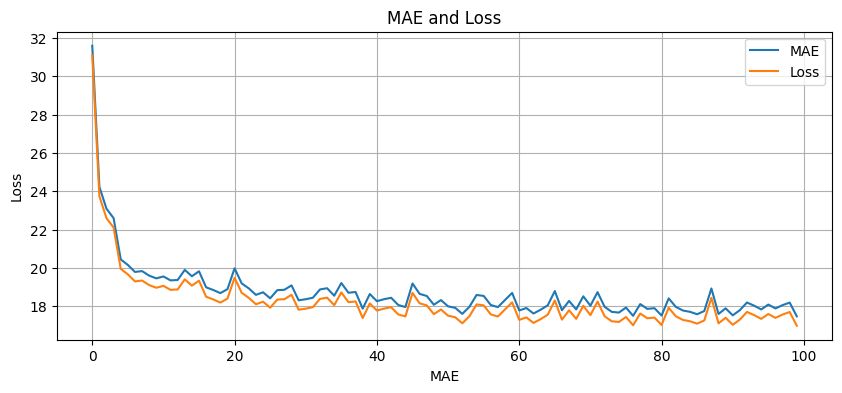

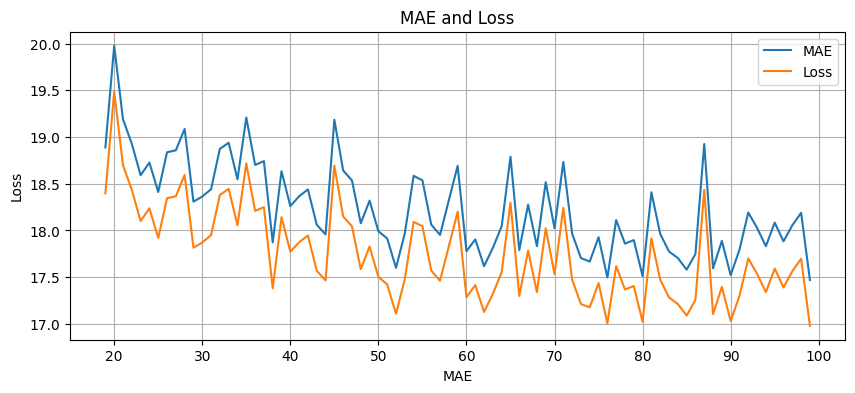

In [19]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss))

# Plot mae and loss
plot_series(
    x=epochs,
    y=(mae, loss),
    title='MAE and Loss',
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom,
    y=(mae_zoom, loss_zoom),
    title='MAE and Loss',
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Model Prediction

In [20]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


2024-07-28 17:39:14.194192: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


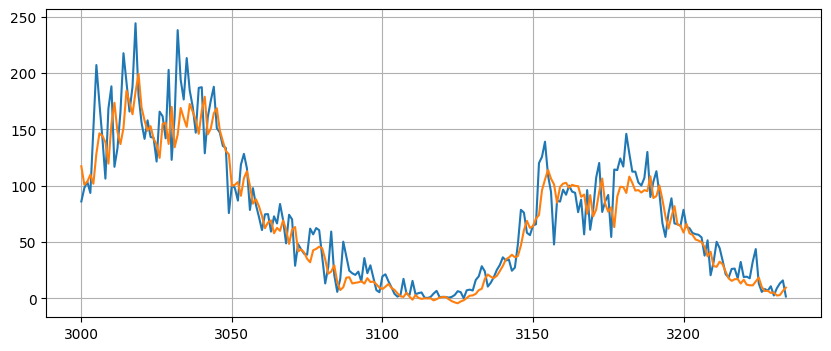

In [21]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [22]:
# Compute the MAE
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

14.857408
